In [34]:
import numpy as np

# Dataframes
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Splitting
from sklearn.model_selection import train_test_split, GridSearchCV

# Model
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import lightgbm as lgb

# Evaluation
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Tuning
import optuna 

In [2]:
from sklearn.datasets import fetch_california_housing
df = fetch_california_housing(as_frame=True).frame

### About this file
Each row is one housing district, also called a block group — a very small geographic area.

Goal: predict the median house value in that district

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. AveRooms: Average number of rooms per household.

Formula: 
```
AveRooms = total rooms / households
```

5. AveBedrooms: Average number of bedrooms per household.

6. population: Total number of people residing within a block

7. AveOccup: Average number of occupants per household.

Formula
```
AveOccup = Population / Households

```

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars) x 10000 $

9. medianHouseValue: Median house value for households within a block (measured in US Dollars) x 100000 $

10. oceanProximity: Location of the house w.r.t ocean/sea

In [3]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
df.shape

(20640, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


**No Nulls + All is numerical**

### EDA

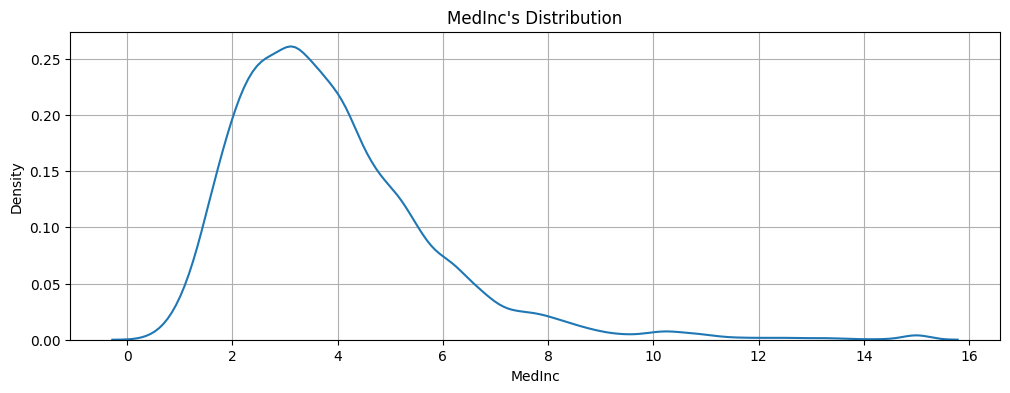

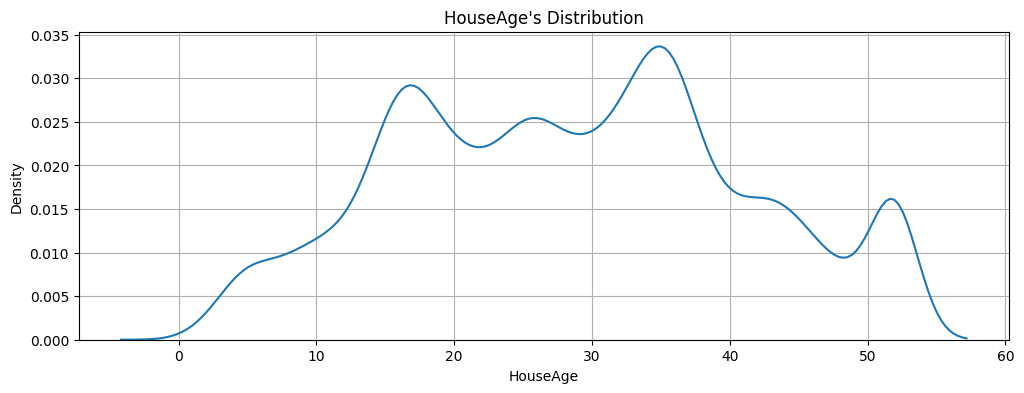

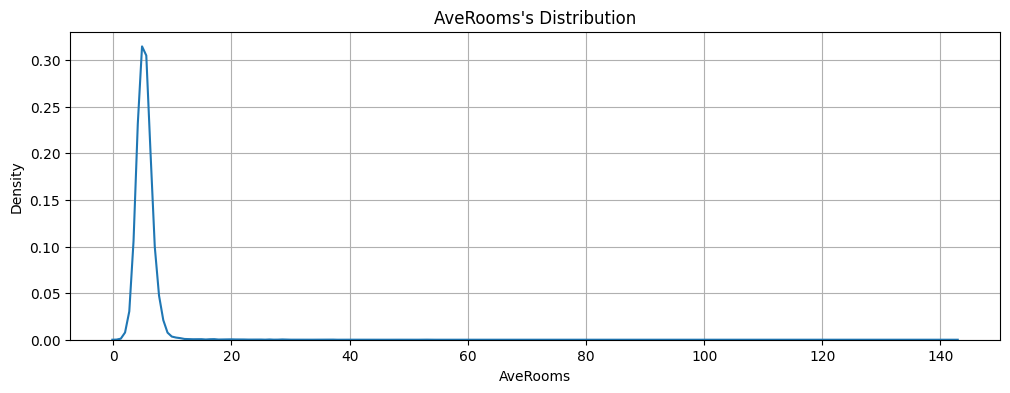

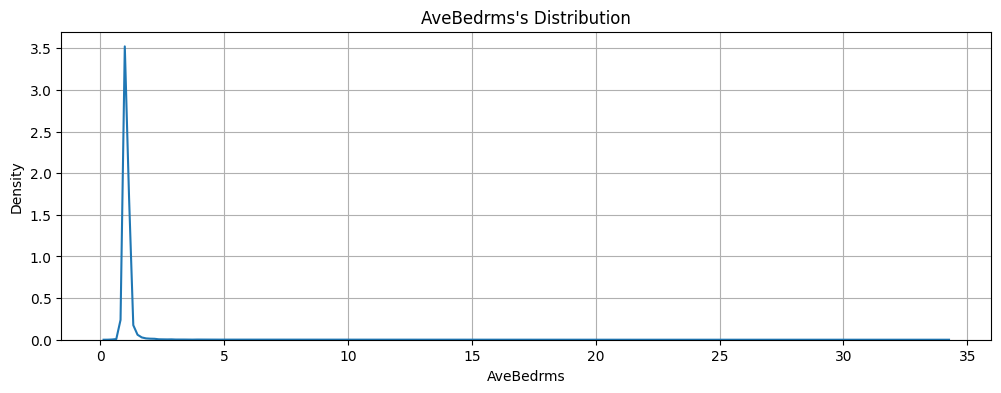

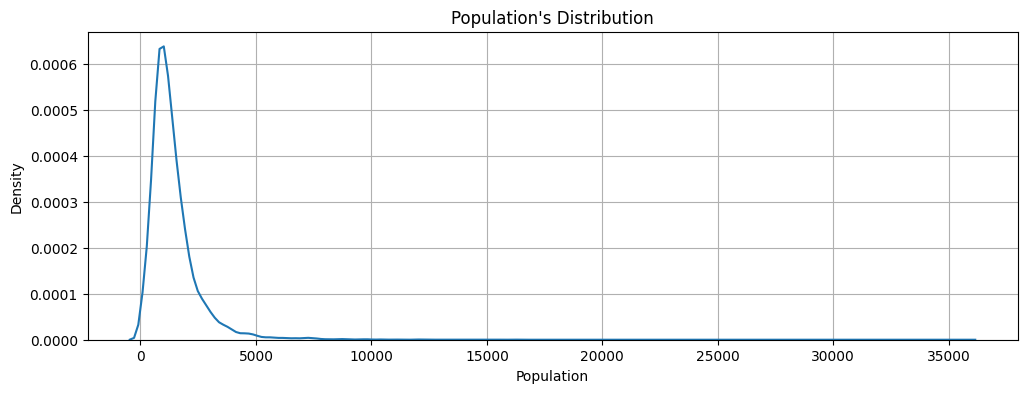

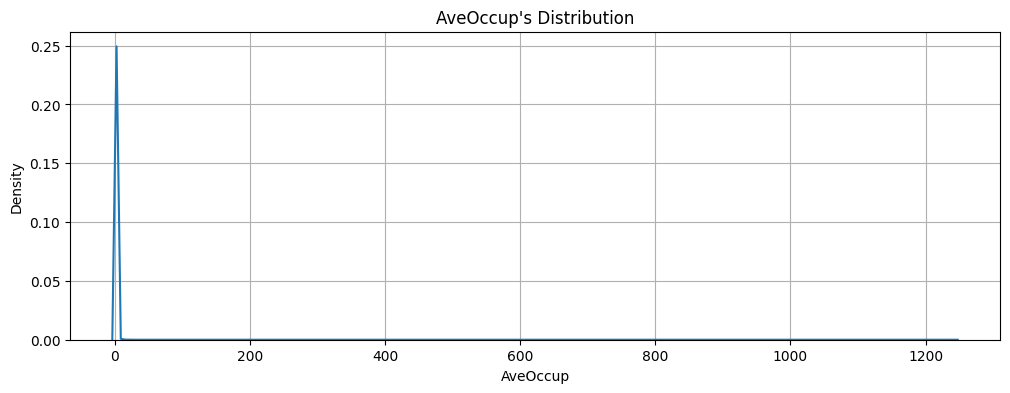

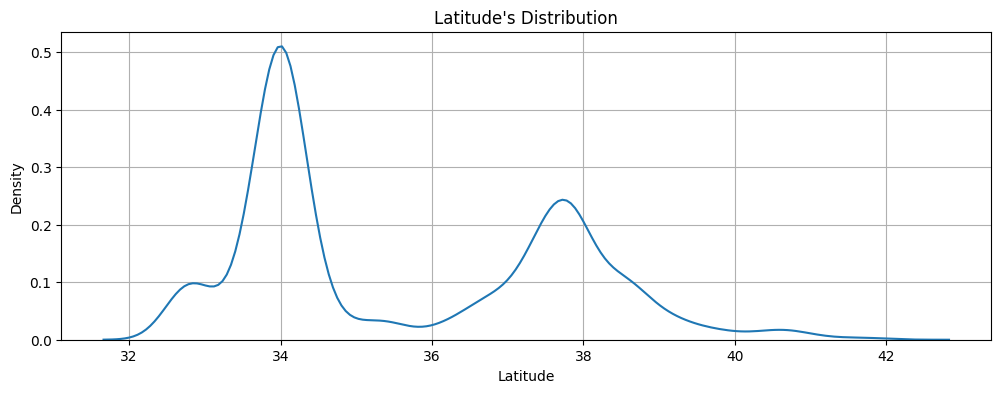

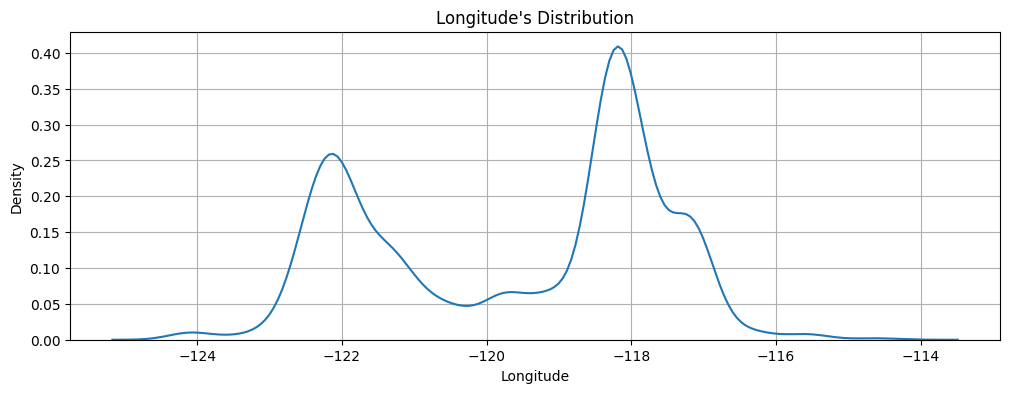

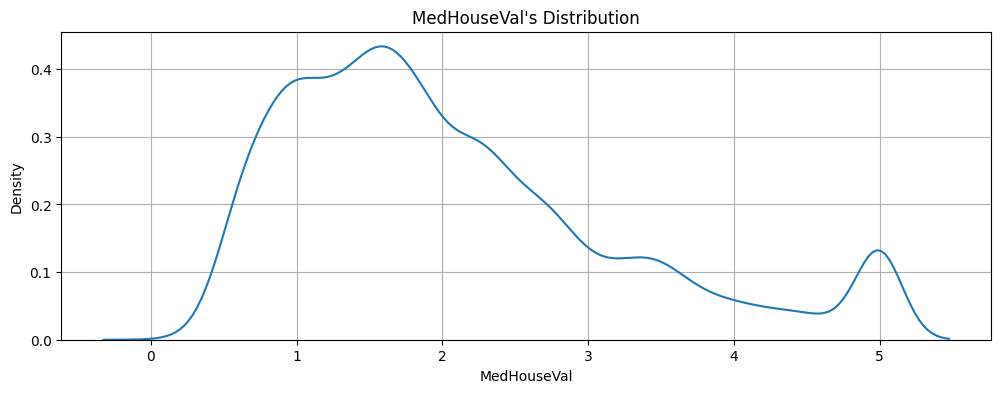

In [6]:
for i in range(df.shape[1]):
    feature = df.columns[i]

    plt.figure(figsize=(12, 4))
    sns.kdeplot(df[feature])
    plt.title(f"{feature}'s Distribution")
    plt.grid(True)
    plt.show()

In [7]:
for i in range(df.shape[1]):
    feature = df.columns[i]
    print(f"{feature} Range: ({df[feature].min()} -> {df[feature].max()})")

MedInc Range: (0.4999 -> 15.0001)
HouseAge Range: (1.0 -> 52.0)
AveRooms Range: (0.8461538461538461 -> 141.9090909090909)
AveBedrms Range: (0.3333333333333333 -> 34.06666666666667)
Population Range: (3.0 -> 35682.0)
AveOccup Range: (0.6923076923076923 -> 1243.3333333333333)
Latitude Range: (32.54 -> 41.95)
Longitude Range: (-124.35 -> -114.31)
MedHouseVal Range: (0.14999 -> 5.00001)


**Notes**
- we have few huge districts which causes the skeweness in each (AveRooms, AveBedrms, Population, AveOccup)
- The skeweness in the MedInc is normal 
- Most of the houses are older than 10 years

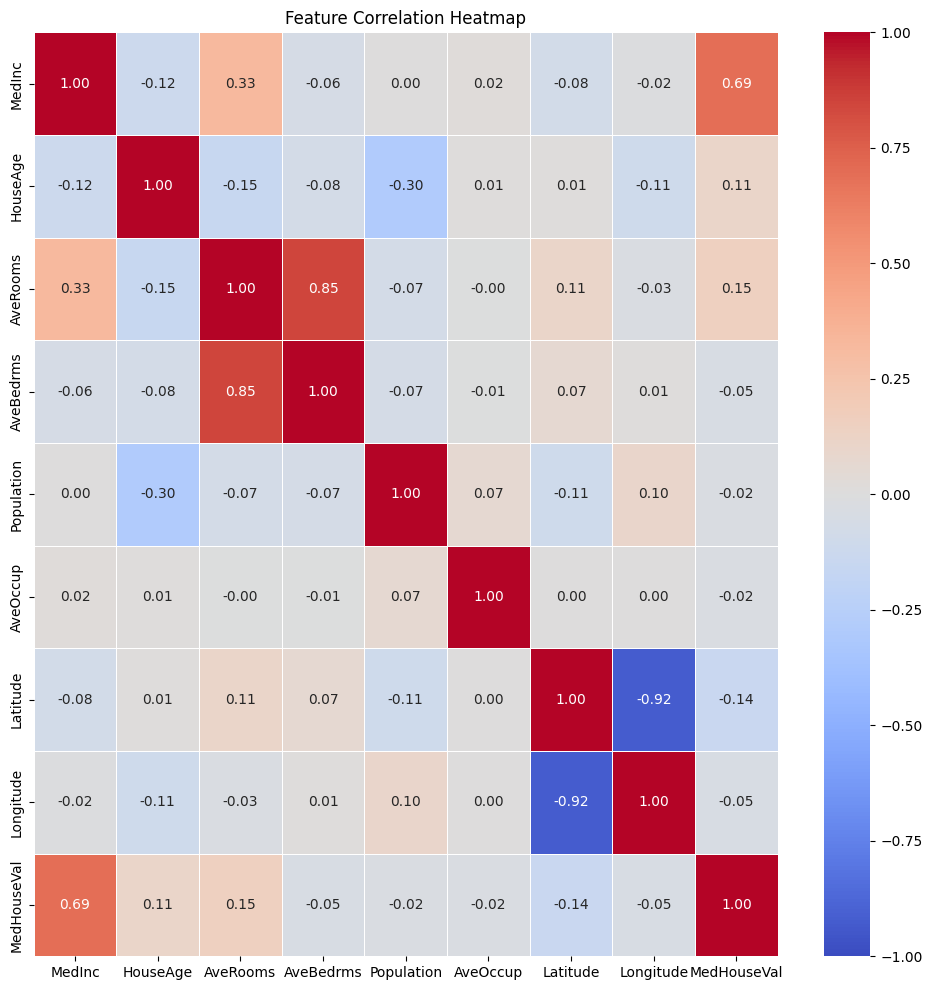

In [8]:
# Plot correlation heatmap

corr_matrix = df.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

**Notes**

- Median Income is by far the strongest predictor of Median House Value.
No other feature comes close in correlation strength.

- Other features show only weak or moderate relationships with house value.
Examples: AveRooms, AveBedrms, Population, and AveOccup have very low correlation with price.

- Older districts tend to have slightly lower population counts,
but the relationship is weak and not strongly predictive.

### Feature Engineering

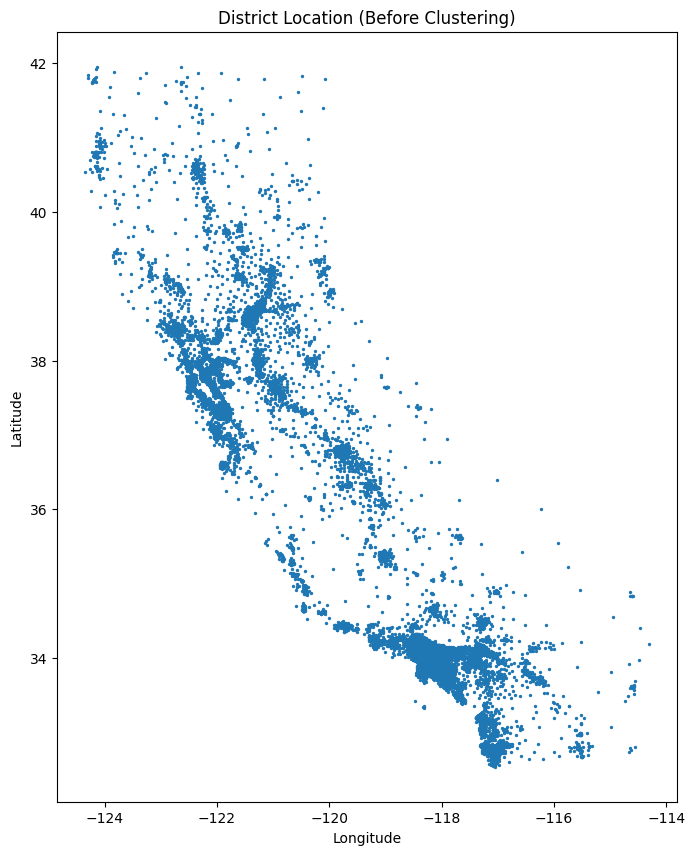

In [9]:
# Cluser data into neighborhoods

plt.figure(figsize=(8, 10))
plt.scatter(df["Longitude"], df["Latitude"], s=2)
plt.title("District Location (Before Clustering)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

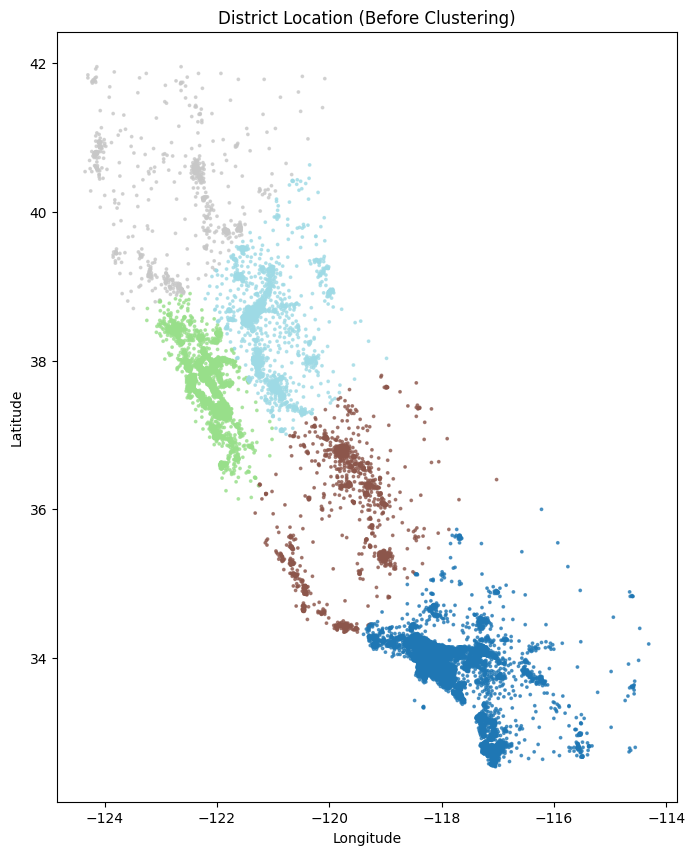

In [10]:
k = 5

coords = df[["Longitude", "Latitude"]]
kmeans = KMeans(n_clusters=k, random_state=42)
df["geo_clusters"] = kmeans.fit_predict(coords)

plt.figure(figsize=(8, 10))
plt.scatter(df["Longitude"], df["Latitude"], c=df['geo_clusters'], s=3,
            alpha=0.7, cmap='tab20')
plt.title("District Location (Before Clustering)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

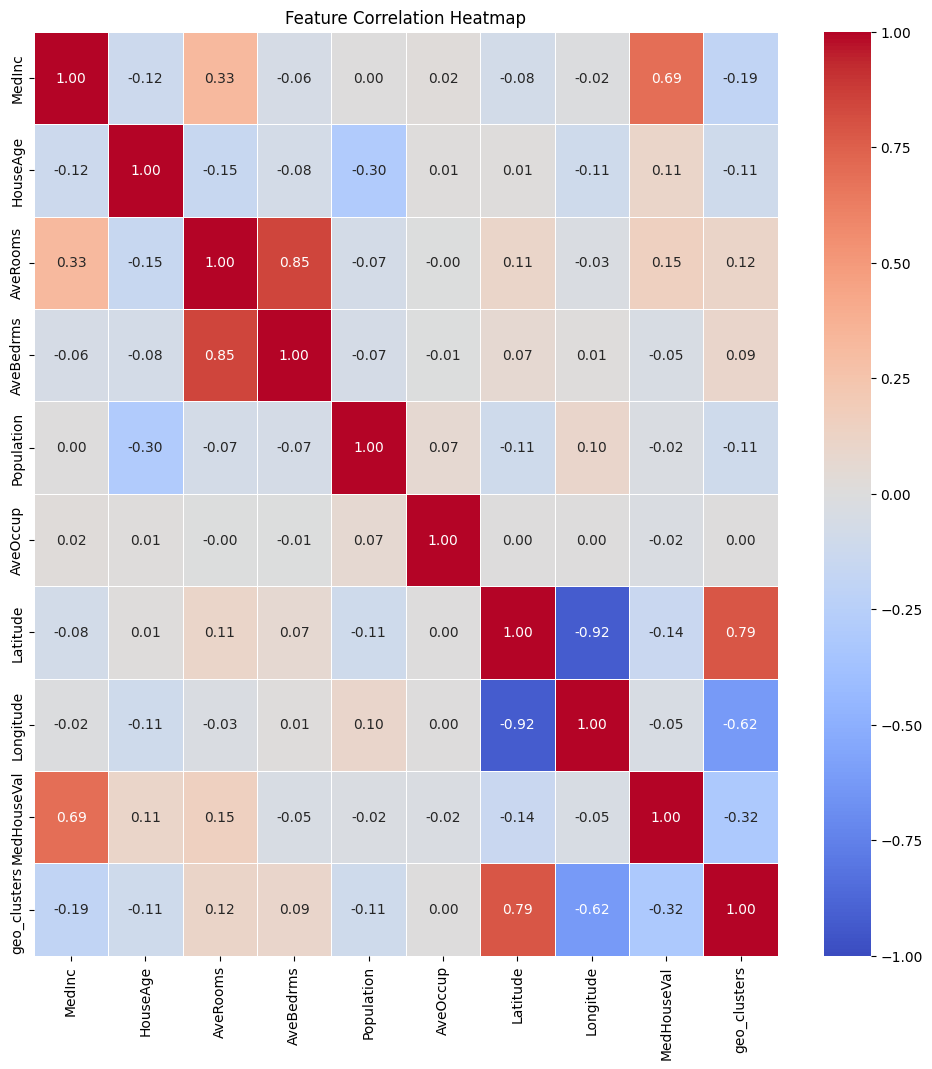

In [11]:
# Plot correlation heatmap

corr_matrix = df.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

**5 clusters to get the highest correlation value**

In [12]:
df.groupby('geo_clusters')[['MedInc','MedHouseVal','Population', 'HouseAge']].mean()

,MedInc,MedHouseVal,Population,HouseAge
geo_clusters,,,,
0,3.985548,2.196696,1542.504036,28.693933
1,4.467357,2.630364,1350.671153,32.146407
2,3.032863,1.247857,1275.176172,25.014116
3,2.471842,0.921754,1014.469477,24.614826
4,3.138631,1.258464,1261.920430,25.049892


- cluster 1 is the richest (highest income/ highest value) districts
- cluster 0 is probably upper middle (most population)
- clusters 2 and 4 are middle 
- cluster 3 is the poorist with the least population 

In [13]:
# Refill the geo_clusters feature based on the income rate (poorest - richest) (0 - 4)
# Rank clusters: 0 = poorest, 4 = richest
cluster_income = df.groupby('geo_clusters')['MedInc'].mean().sort_values()
income_rank = cluster_income.rank(method='dense').astype(int) - 1
rank_map = income_rank.to_dict()
df['geo_clusters'] = df['geo_clusters'].map(rank_map)


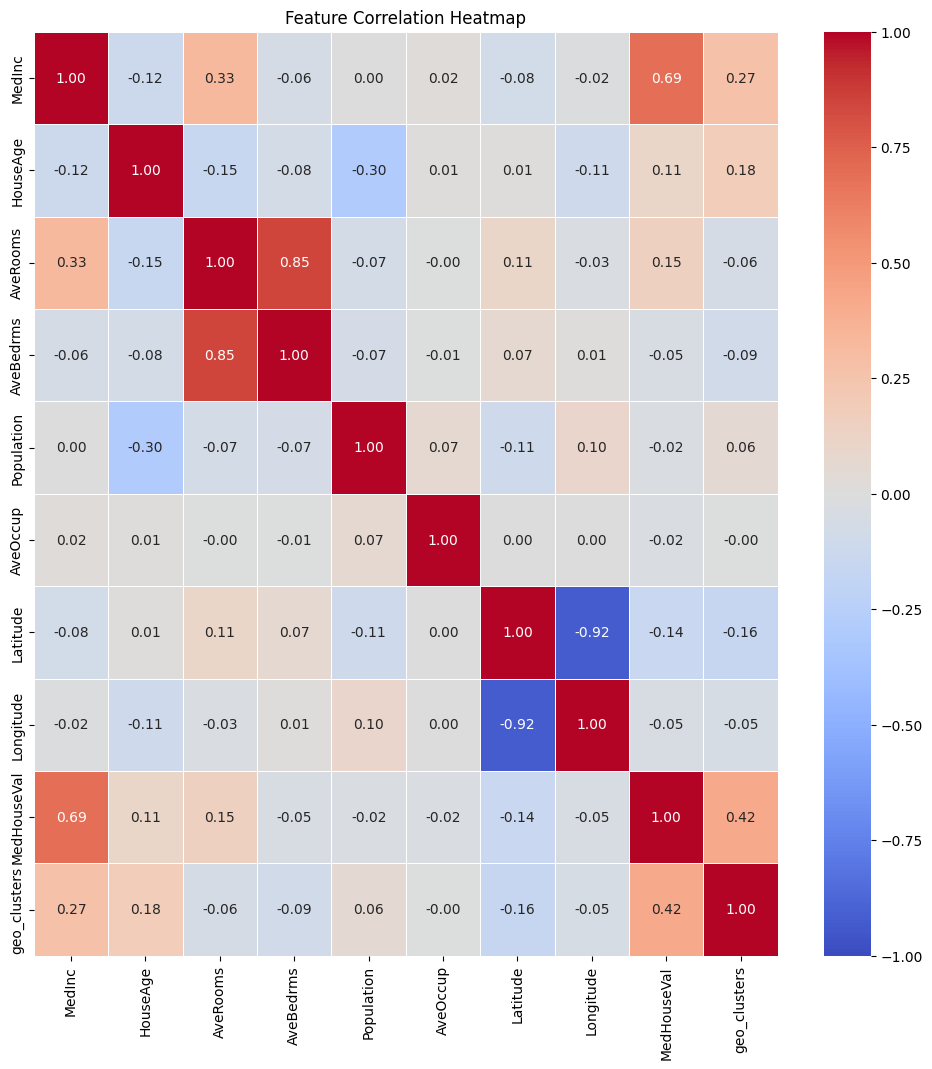

In [14]:
# Plot correlation heatmap

corr_matrix = df.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

**correlation between geo_clusters and houseVal went higher**

In [15]:
# tried different opertaions, these are with the highest corr
df['bedroom_ratio'] = df['AveBedrms'] / df['AveRooms']
df['cluster_income'] = df['MedInc'] * df['geo_clusters'] 

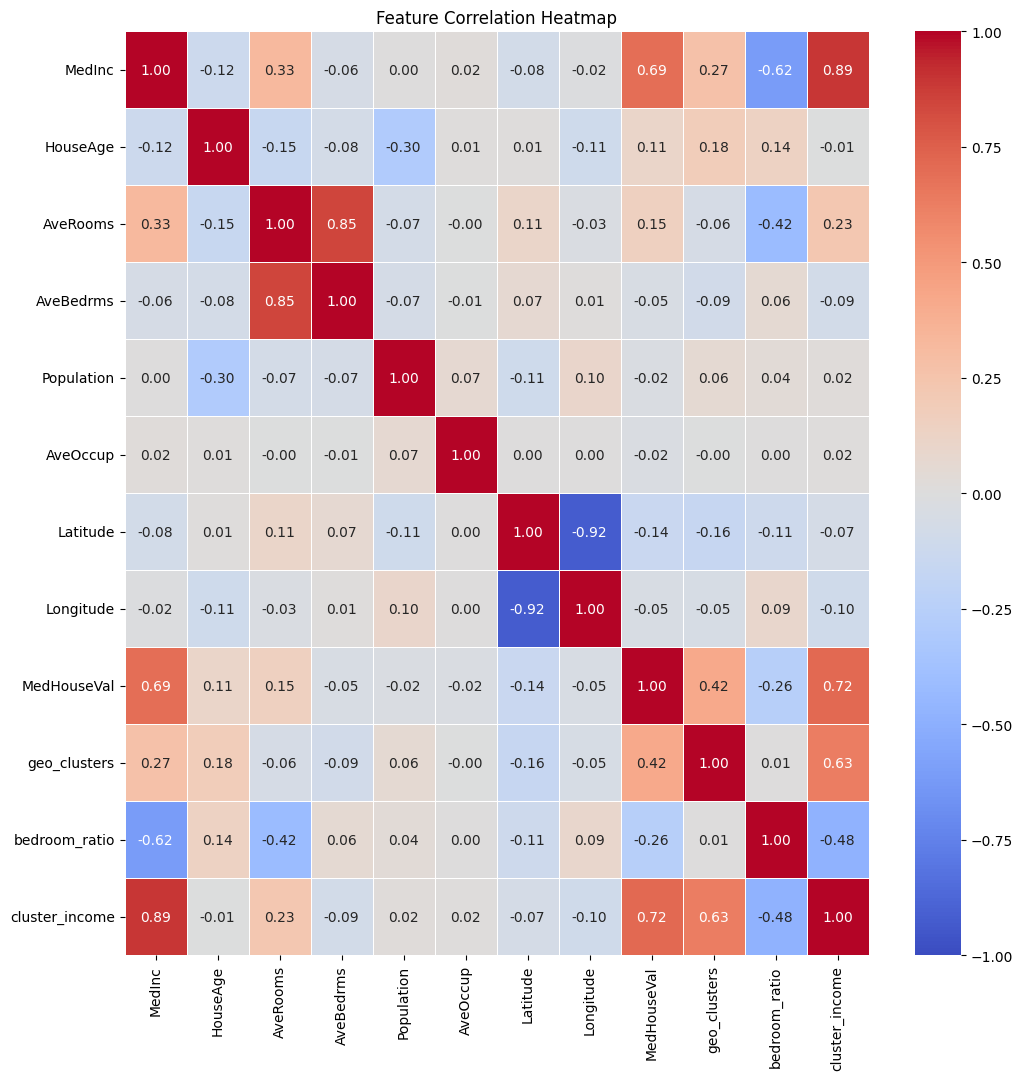

In [16]:
# Plot correlation heatmap

corr_matrix = df.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

### Data Preprocessing

In [17]:
# Remove skeweness using log transformation

df["AveRooms"] = np.log(df["AveRooms"])
df["AveBedrms"] = np.log(df["AveBedrms"])
df["Population"] = np.log(df["Population"])
df["AveOccup"] = np.log(df["AveOccup"])

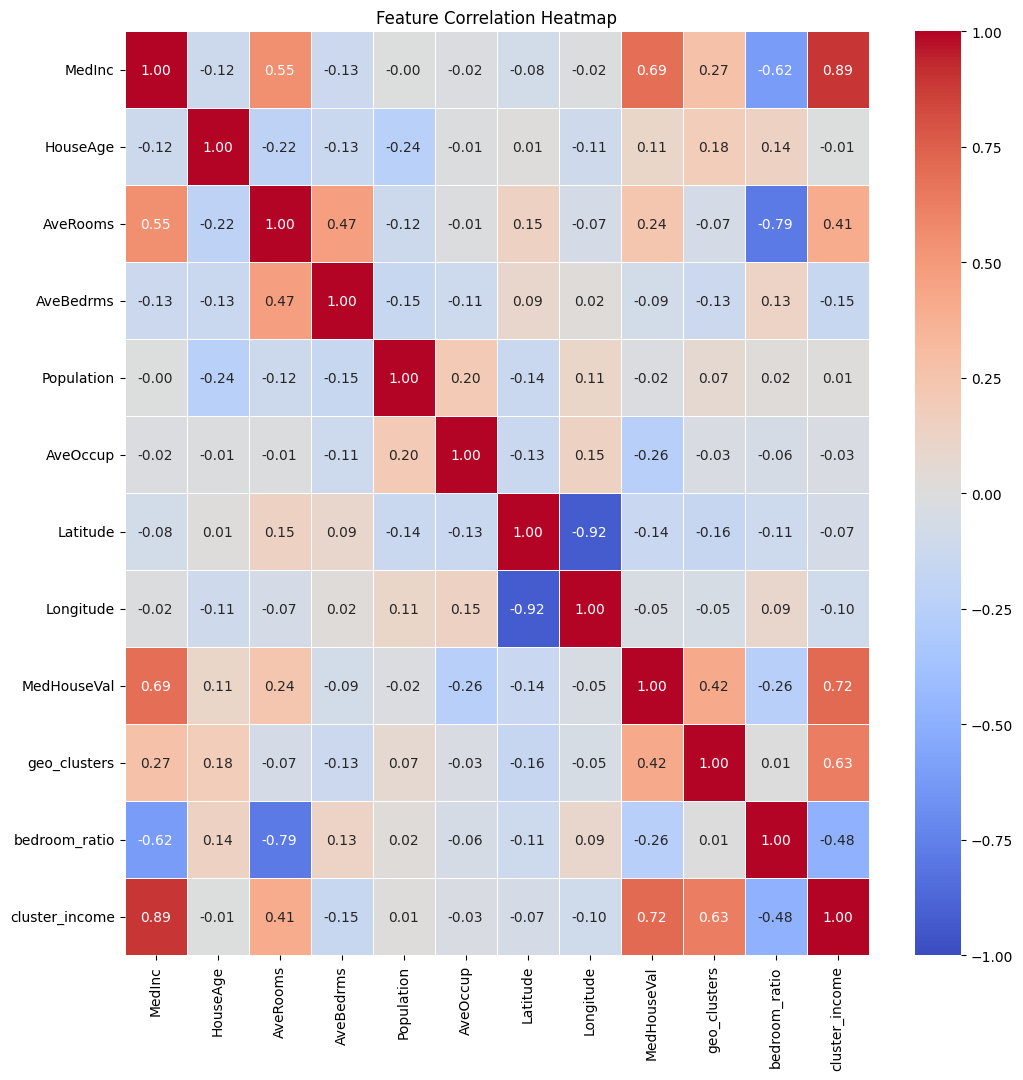

In [18]:
# Plot correlation heatmap

corr_matrix = df.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [19]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))

Regression Report: 
explained_variance:  0.6563
r2:  0.6563
MAE:  0.4851
MSE:  0.4504
           Feature  Importance
9    bedroom_ratio    3.906627
5         AveOccup    0.974078
2         AveRooms    0.459827
6         Latitude    0.379246
7        Longitude    0.371332
0           MedInc    0.366615
4       Population    0.063488
3        AveBedrms    0.043617
8     geo_clusters    0.030101
10  cluster_income    0.014658
1         HouseAge    0.010842


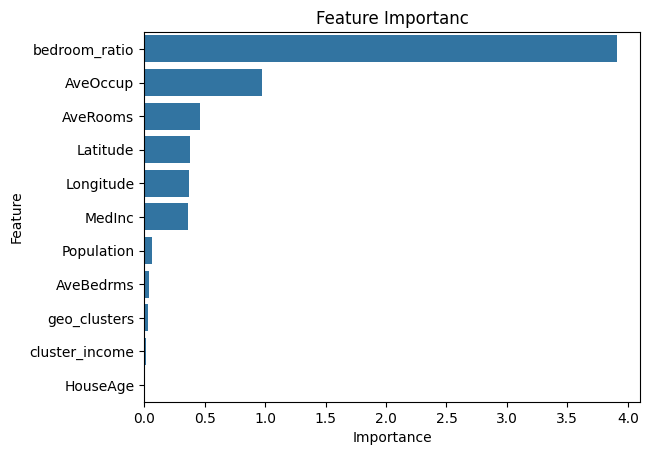

In [20]:
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
print("Regression Report: ")
regression_results(y_true=y_test, y_pred=y_pred)

importances = lr_model.coef_
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": abs(importances)})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print(feature_importance_df)

sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importanc")
plt.show()


### Modeling (Optuna)

In [35]:
def objective(trial):
    # select regressor
    reg_name = trial.suggest_categorical(
        "regressor" , ['LinearRegression', 'SVR', 'RandomForest', 'XGBoost', 'LightGBM']
    )

    X = df.drop(columns="MedHouseVal")
    y = df["MedHouseVal"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

    # scaling flag
    if reg_name in ['LinearRegression', 'SVR']:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)


    if reg_name == "LinearRegression":
        regressor = LinearRegression()

    elif reg_name == "SVR":
        svr_c = trial.suggest_float("svr_c", 1e-3, 1e3, log=True)
        svr_eps = trial.suggest_float("svr_eps", 0.01, 1.0, log=True)
        regressor = SVR(C= svr_c, epsilon=svr_eps)

    elif reg_name == "RandomForest":
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 500)
        regressor = RandomForestRegressor(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators, random_state=42
        )
        
    elif reg_name == "XGBoost":
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 20)
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 50, 500)
        xgb_lr = trial.suggest_float("xgb_lr", 0.01, 0.3, log=True)
        regressor = XGBRegressor(
            max_depth=xgb_max_depth, n_estimators=xgb_n_estimators,
            learning_rate=xgb_lr, random_state=42, verbosity=0
        )
    
    elif reg_name == "LightGBM":
        lgb_max_depth = trial.suggest_int("lgb_max_depth", 2, 32)
        lgb_n_estimators = trial.suggest_int("lgb_n_estimators", 50, 500)
        lgb_lr = trial.suggest_float("lgb_lr", 0.01, 0.3, log=True)
        regressor = lgb.LGBMRegressor(
            max_depth=lgb_max_depth, n_estimators=lgb_n_estimators,
            learning_rate=lgb_lr, random_state=42
        )

    # Fit 
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = metrics.mean_squared_error(y_test, y_pred)

    return mse


# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40) 

print("Best trial:")
trial = study.best_trial
print(f"Regressor: {trial.params['regressor']}")
print(f"MSE: {trial.value:.4f}")
print(f"Hyperparameters: {trial.params}") 

[I 2025-11-05 23:23:07,685] A new study created in memory with name: no-name-95006d10-8b51-4445-a900-f93cccac51cb
[I 2025-11-05 23:23:07,717] Trial 0 finished with value: 0.43813366907854534 and parameters: {'regressor': 'LinearRegression'}. Best is trial 0 with value: 0.43813366907854534.
[I 2025-11-05 23:24:08,231] Trial 1 finished with value: 0.23351478782104051 and parameters: {'regressor': 'RandomForest', 'rf_max_depth': 15, 'rf_n_estimators': 233}. Best is trial 1 with value: 0.23351478782104051.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:24:09,083] Trial 2 finished with value: 0.20433911850757966 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 31, 'lgb_n_estimators': 272, 'lgb_lr': 0.22465275466929027}. Best is trial 2 with value: 0.20433911850757966.
[I 2025-11-05 23:24:43,933] Trial 3 finished with value: 0.2399380631306811 and parameters: {'regressor': 'XGBoost', 'xgb_max_depth': 15, 'xgb_n_estimators': 347, 'xgb_lr': 0.027844377356116508}. Best is trial 2 with value: 0.20433911850757966.
[I 2025-11-05 23:24:44,007] Trial 4 finished with value: 0.43813366907854534 and parameters: {'regressor': 'LinearRegression'}. Best is trial 2 with value: 0.20433911850757966.
[I 2025-11-05 23:24:44,063] Trial 5 finished with value: 0.43813366907854534 and parameters: {'regressor': 'LinearRegression'}. Best is trial 2 with value: 0.20433911850757966.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:24:45,351] Trial 6 finished with value: 0.20266558506857496 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 25, 'lgb_n_estimators': 363, 'lgb_lr': 0.23337295443700812}. Best is trial 6 with value: 0.20266558506857496.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:24:45,760] Trial 7 finished with value: 0.49132459875202655 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 23, 'lgb_n_estimators': 82, 'lgb_lr': 0.011906470760059885}. Best is trial 6 with value: 0.20266558506857496.
[I 2025-11-05 23:24:45,808] Trial 8 finished with value: 0.43813366907854534 and parameters: {'regressor': 'LinearRegression'}. Best is trial 6 with value: 0.20266558506857496.
[I 2025-11-05 23:24:46,965] Trial 9 finished with value: 0.24444203531264255 and parameters: {'regressor': 'XGBoost', 'xgb_max_depth': 4, 'xgb_n_estimators': 415, 'xgb_lr': 0.024669346796640818}. Best is trial 6 with value: 0.20266558506857496.
[I 2025-11-05 23:26:31,783] Trial 10 finished with value: 0.3067687323247975 and parameters: {'regressor': 'SVR', 'svr_c': 54.75694859357833, 'svr_eps': 0.1955200969549384}. Best is trial 6 with value: 0.20266558506857496.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:26:32,968] Trial 11 finished with value: 0.20600965628803883 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 32, 'lgb_n_estimators': 376, 'lgb_lr': 0.29735002953065887}. Best is trial 6 with value: 0.20266558506857496.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:26:33,915] Trial 12 finished with value: 0.2079398314395227 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 29, 'lgb_n_estimators': 300, 'lgb_lr': 0.2797256960628951}. Best is trial 6 with value: 0.20266558506857496.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-05 23:26:35,433] Trial 13 finished with value: 0.19294652351204458 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 10, 'lgb_n_estimators': 469, 'lgb_lr': 0.09951019588091271}. Best is trial 13 with value: 0.19294652351204458.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-05 23:26:37,171] Trial 14 finished with value: 0.19282210095726623 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 8, 'lgb_n_estimators': 492, 'lgb_lr': 0.07516174517981922}. Best is trial 14 with value: 0.19282210095726623.
[I 2025-11-05 23:27:23,199] Trial 15 finished with value: 0.8126965938676262 and parameters: {'regressor': 'SVR', 'svr_c': 0.0011655067899865703, 'svr_eps': 0.01117229634915615}. Best is trial 14 with value: 0.19282210095726623.
[I 2025-11-05 23:30:42,627] Trial 16 finished with value: 0.22996616426127833 and parameters: {'regressor': 'RandomForest', 'rf_max_depth': 30, 'rf_n_estimators': 462}. Best is trial 14 with value: 0.19282210095726623.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-11-05 23:30:44,205] Trial 17 finished with value: 0.19592229607719594 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 6, 'lgb_n_estimators': 484, 'lgb_lr': 0.06998759041721088}. Best is trial 14 with value: 0.19282210095726623.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-11-05 23:30:45,967] Trial 18 finished with value: 0.19248257949241634 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 8, 'lgb_n_estimators': 497, 'lgb_lr': 0.06690480820694776}. Best is trial 18 with value: 0.19248257949241634.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:30:47,850] Trial 19 finished with value: 0.20520134004211657 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 14, 'lgb_n_estimators': 497, 'lgb_lr': 0.02503053096170546}. Best is trial 18 with value: 0.19248257949241634.
[I 2025-11-05 23:30:57,268] Trial 20 finished with value: 0.7341227320769703 and parameters: {'regressor': 'SVR', 'svr_c': 0.0037876281449038267, 'svr_eps': 0.9980579603875471}. Best is trial 18 with value: 0.19248257949241634.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-05 23:30:58,857] Trial 21 finished with value: 0.19380699706582424 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 8, 'lgb_n_estimators': 497, 'lgb_lr': 0.07959850260422595}. Best is trial 18 with value: 0.19248257949241634.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:31:00,257] Trial 22 finished with value: 0.19362168507914093 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 11, 'lgb_n_estimators': 417, 'lgb_lr': 0.09991872241271603}. Best is trial 18 with value: 0.19248257949241634.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-11-05 23:31:00,845] Trial 23 finished with value: 0.3011277447082907 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 2, 'lgb_n_estimators': 430, 'lgb_lr': 0.03969063214906055}. Best is trial 18 with value: 0.19248257949241634.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:31:02,248] Trial 24 finished with value: 0.19255935051339018 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 13, 'lgb_n_estimators': 429, 'lgb_lr': 0.12252502552755185}. Best is trial 18 with value: 0.19248257949241634.
[I 2025-11-05 23:31:11,434] Trial 25 finished with value: 0.40133379521802703 and parameters: {'regressor': 'RandomForest', 'rf_max_depth': 5, 'rf_n_estimators': 61}. Best is trial 18 with value: 0.19248257949241634.
[I 2025-11-05 23:31:22,670] Trial 26 finished with value: 0.26038365897618304 and parameters: {'regressor': 'XGBoost', 'xgb_max_depth': 20, 'xgb_n_estimators': 83, 'xgb_lr': 0.2856432766073438}. Best is trial 18 with value: 0.19248257949241634.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:31:23,977] Trial 27 finished with value: 0.1922796531206733 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 17, 'lgb_n_estimators': 397, 'lgb_lr': 0.14468454831638658}. Best is trial 27 with value: 0.1922796531206733.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:31:25,002] Trial 28 finished with value: 0.19852937402385293 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 18, 'lgb_n_estimators': 331, 'lgb_lr': 0.15441600256970034}. Best is trial 27 with value: 0.1922796531206733.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:31:25,861] Trial 29 finished with value: 0.19633632960101344 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 17, 'lgb_n_estimators': 229, 'lgb_lr': 0.14600280332595875}. Best is trial 27 with value: 0.1922796531206733.
[I 2025-11-05 23:34:02,543] Trial 30 finished with value: 0.22979830559770542 and parameters: {'regressor': 'RandomForest', 'rf_max_depth': 32, 'rf_n_estimators': 470}. Best is trial 27 with value: 0.1922796531206733.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:34:04,074] Trial 31 finished with value: 0.19806979276779263 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 14, 'lgb_n_estimators': 425, 'lgb_lr': 0.04709276822151649}. Best is trial 27 with value: 0.1922796531206733.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-11-05 23:34:05,182] Trial 32 finished with value: 0.19854351285396482 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 5, 'lgb_n_estimators': 426, 'lgb_lr': 0.13484834155299721}. Best is trial 27 with value: 0.1922796531206733.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:34:06,780] Trial 33 finished with value: 0.19477844159512334 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 13, 'lgb_n_estimators': 448, 'lgb_lr': 0.06215218873024922}. Best is trial 27 with value: 0.1922796531206733.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:34:08,115] Trial 34 finished with value: 0.19332398359329853 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 18, 'lgb_n_estimators': 385, 'lgb_lr': 0.09855104333224159}. Best is trial 27 with value: 0.1922796531206733.
[I 2025-11-05 23:34:08,343] Trial 35 finished with value: 0.29696896182449 and parameters: {'regressor': 'XGBoost', 'xgb_max_depth': 2, 'xgb_n_estimators': 118, 'xgb_lr': 0.17338702106318574}. Best is trial 27 with value: 0.1922796531206733.
[I 2025-11-05 23:34:08,400] Trial 36 finished with value: 0.43813366907854534 and parameters: {'regressor': 'LinearRegression'}. Best is trial 27 with value: 0.1922796531206733.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240


[I 2025-11-05 23:34:10,107] Trial 37 finished with value: 0.2039944123316595 and parameters: {'regressor': 'LightGBM', 'lgb_max_depth': 9, 'lgb_n_estimators': 463, 'lgb_lr': 0.03084909437882536}. Best is trial 27 with value: 0.1922796531206733.
[I 2025-11-06 11:15:07,114] Trial 38 finished with value: 0.37265438724572963 and parameters: {'regressor': 'SVR', 'svr_c': 237.90127175452469, 'svr_eps': 0.010803899124018567}. Best is trial 27 with value: 0.1922796531206733.
[I 2025-11-06 11:15:07,179] Trial 39 finished with value: 0.43813366907854534 and parameters: {'regressor': 'LinearRegression'}. Best is trial 27 with value: 0.1922796531206733.


Best trial:
Regressor: LightGBM
MSE: 0.1923
Hyperparameters: {'regressor': 'LightGBM', 'lgb_max_depth': 17, 'lgb_n_estimators': 397, 'lgb_lr': 0.14468454831638658}


In [36]:
best_reg = trial.params['regressor']

X = df.drop(columns="MedHouseVal")
y = df["MedHouseVal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

if best_reg in ['LinearRegression', 'SVR']:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

if best_reg == "LinearRegression":
    model = LinearRegression()
elif best_reg == "SVR":
    model = SVR(C=trial.params['svr_c'], epsilon=trial.params['svr_eps'])
elif best_reg == "RandomForest":
    model = RandomForestRegressor(
        max_depth=trial.params['rf_max_depth'],
        n_estimators=trial.params['rf_n_estimators'],
        random_state=42
    )
elif best_reg == "XGBoost":
    model = XGBRegressor(
        max_depth=trial.params['xgb_max_depth'],
        n_estimators=trial.params['xgb_n_estimators'],
        learning_rate=trial.params['xgb_lr'],
        random_state=42,
        verbosity=0
    )
elif best_reg == "LightGBM":
    model = lgb.LGBMRegressor(
        max_depth=trial.params['lgb_max_depth'],
        n_estimators=trial.params['lgb_n_estimators'],
        learning_rate=trial.params['lgb_lr'],
        random_state=42
    )

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print all metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPerformance on Test Set:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 11
[LightGBM] [Info] Start training from score 2.069240

Performance on Test Set:
MSE: 0.1923
RMSE: 0.4385
MAE: 0.2888
R²: 0.8535
